In [8]:
%load_ext autoreload
%autoreload 2

import os, sys, pickle
import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt 

from bpreg.evaluation.visualization import plot_data 
from bpreg.settings import *
from bpreg.scripts.train import train_config, train_json


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train and Evaluate Body Part Regression Model 
In this notebook, it will be explained how a body part regression model can be trained and evaluated. A pretrained model of the body part regression model for CT volumes already exists. Nevertheless, training a new model is important if you want to extend the method for new modalities. 

In general, it is very important to create a diverse dataset for training with lots of data from different studies inside. For training the pretrained model, about 2000 CT volumes from 10 different studies were used. 
For demonstration purposes, in this tutorial we will use only one dataset and fewer data with a smaller size. 


## 1. Download data 
For this tutorial, we will use down sampled npy arrays from the [CT Lymph Nodes Dataset](https://wiki.cancerimagingarchive.net/display/Public/CT+Lymph+Nodes). 
Please, download and save the data from Zenodo: 
https://zenodo.org/record/5140026#.YQAfcNaxWEB

During converting the nifti-files to npy arrays with the size of 64 px x 64 px we did the following steps: 
    - downscale to pixel spacing of 64 px x 64 px 
    - pixel-spacing = 7 mm/pixel
    - rescale to -1 and 1 
    - crop Hounsfield scale at -1000 and +1500 
    - apply Gaussian smoothing before down sampling to reduce aliasing effects
    
If you want to understand the done preprocessing steps better, refer to the function `preprocess_ct_lymph_node_dataset` in `docs/notebooks/utils.py`. 

To be able to evaluate the Body Part Regression model, a landmark file is saved in `docs/notebooks/data/ct-lymph-nodes-annotated-landmarks.xlsx`. For a subset of the training data and for the test data, the slice index was annotated for several landmarks. As evaluation landmarks, we are using bone landmarks instead of organ landmarks because bone landmarks are more robust and have a smaller variation across patients. 
In this example, we will use the landmarks: pelvis-start, femur-end, L5, L3, L1, Th11, Th8, Th5, and Th2 for evaluation.  In general, the centroid of the spines work well as evaluation landmarks. The spine landmarks can get automatically annotated with a vertebra [nnU-Net](https://github.com/MIC-DKFZ/nnUNet). 

For the sake of simplicity, we only have a training and a test set (and no validation set).

## 2. Define Settings
To run the Body Part Regression model, we need to set some settings and save them in a json-file. 



In [9]:
# Define data paths
data_path = "data/ct-lymph-node-downsampled/CT Lymph Node npy/"
meta_data_path = "data/ct-lymph-node-downsampled/meta_data.xlsx"
landmark_path = "data/ct-lymph-nodes-annotated-landmarks.xlsx"

In [10]:
# Create config for training
params = {"df_data_source_path": meta_data_path, 
          "data_path": data_path, 
          "landmark_path": landmark_path, 
          "save_dir": "data/", 
          "model_name": "ct_lymph_node_standard_run"}

# define params for data augmentations
transform_params = TRANSFORM_STANDARD_PARAMS
transform_params["AddFrame"]["dimension"] = 64
params["transform_params"] = transform_params 

config = ModelSettings(**params)
print(config)

# save config as json 
config.save("data/bpr-config.json")


BODY PART REGRESSION MODEL SETTINGS
*******************************************************
model_name                  :	ct_lymph_node_standard_run
name                        :	default.p
df_data_source_path         :	data/ct-lymph-node-downsampled/meta_data.xlsx
data_path                   :	data/ct-lymph-node-downsampled/CT Lymph Node npy/
landmark_path               :	data/ct-lymph-nodes-annotated-landmarks.xlsx
save_dir                    :	data/
shuffle_train_dataloader    :	True
random_seed                 :	0
deterministic               :	True
save_model                  :	True
base_model                  :	vgg
*******************************************************
batch_size                  :	64
effective_batch_size        :	64
equidistance_range          :	[5, 100]
num_slices                  :	4
*******************************************************
alpha_h                     :	1
beta_h                      :	0.01
loss_order                  :	h
lambda_                 

TRAINING DATA


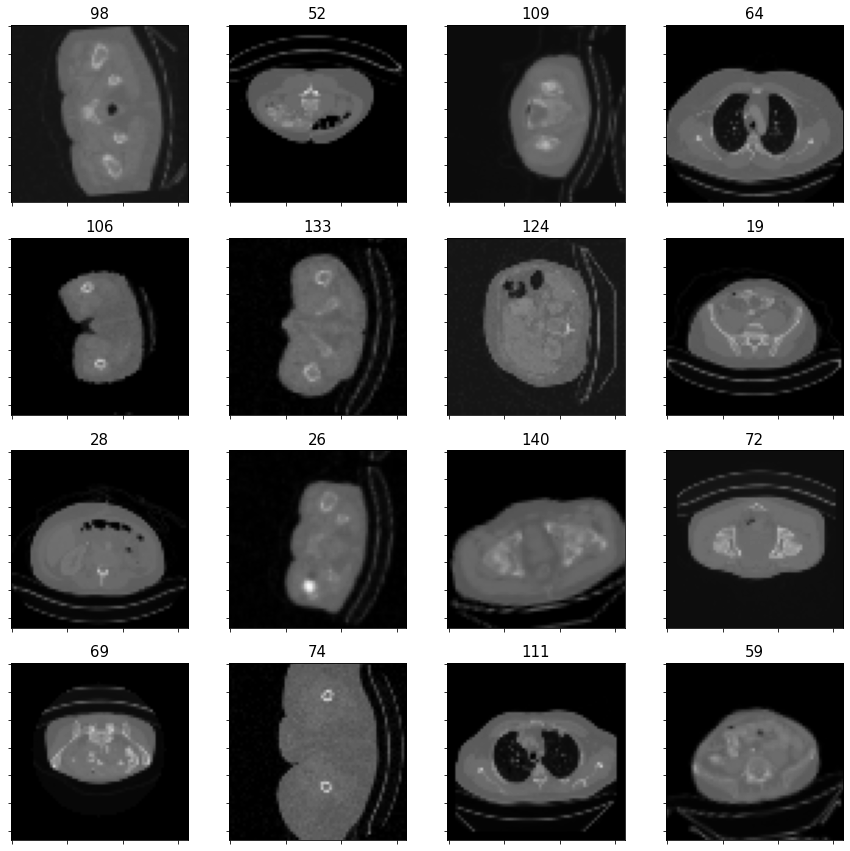

TEST DATA


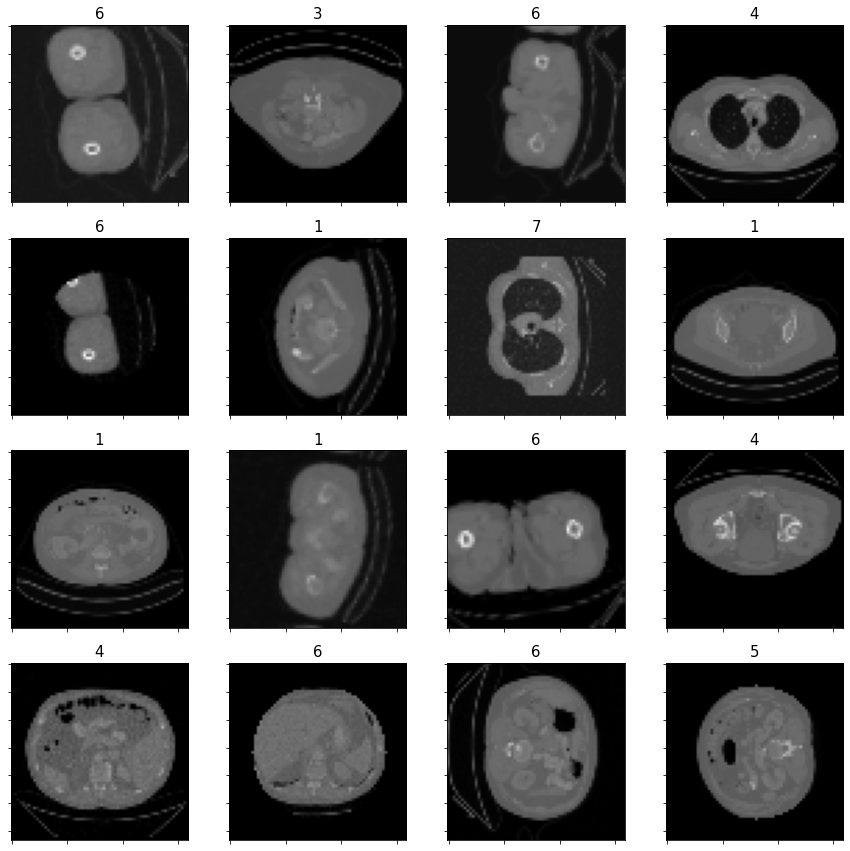

In [11]:
# plot training data 
print("TRAINING DATA")
plot_data(config, kind="train", cols=4, rows=4)
# plot test data 
print("TEST DATA")
plot_data(config, kind="test", cols=4, rows=4)

# 3. Train model

In [12]:
# train config 
train_json("data/bpr-config.json")

Global seed set to 0



BODY PART REGRESSION MODEL SETTINGS
*******************************************************
model_name                  :	ct_lymph_node_standard_run
name                        :	default.p
df_data_source_path         :	data/ct-lymph-node-downsampled/meta_data.xlsx
data_path                   :	data/ct-lymph-node-downsampled/CT Lymph Node npy/
landmark_path               :	data/ct-lymph-nodes-annotated-landmarks.xlsx
save_dir                    :	data/
shuffle_train_dataloader    :	True
random_seed                 :	0
deterministic               :	True
save_model                  :	True
base_model                  :	vgg
*******************************************************
batch_size                  :	64
effective_batch_size        :	64
equidistance_range          :	[5, 100]
num_slices                  :	4
*******************************************************
alpha_h                     :	1
beta_h                      :	0.01
loss_order                  :	h
lambda_                 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type         | Params
----------------------------------------
0 | l1loss | SmoothL1Loss | 0     
1 | conv6  | Conv2d       | 262 K 
2 | fc7    | Linear       | 513   
3 | model  | Sequential   | 14.7 M
----------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
59.907    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type         | Params
----------------------------------------
0 | l1loss | SmoothL1Loss | 0     
1 | conv6  | Conv2d       | 262 K 
2 | fc7    | Linear       | 513   
3 | model  | Sequential   | 14.7 M
----------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
59.907    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/AD/s429r/anaconda3/envs/plightning5/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


save model at:  data/ct_lymph_node_standard_run/version_1/


# 4. Prepare model for inference 

- create inference-settings.json file to use the model for inference. In the inference-file, you will find the following tags: 
    - slope mean, slope_median, slope_std:  
        mean, median and standard deviation of slope of slice score curves for training data
    - tagential_slope_mean, upper_quantile_tangential_slope, lower_quantiel_tangential_slope: 
        mean, upper quantile and lower quantile of tangential slopes from the training data. 
        The tangential slope is the slope on one data point. 
    - lookuptable_train: expected scores for different anatomies based on annotated data from the training data 
    - lookuptable_train_val: expected scores for different anatomies based on annotated data from the training and validation data. 



In [13]:
from bpreg.inference.inference_settings import postprocess_model_for_inference

postprocess_model_for_inference("data/ct_lymph_node_standard_run/version_0/", 
                       df_data_source_path=meta_data_path, 
                       landmark_path=landmark_path,  
                       data_path=data_path, 
                       transform_min_landmark="pelvis_start", 
                       transform_max_landmark="Th2")

Initialize model.


  1%|          | 1/167 [00:00<00:26,  6.35it/s]

Load lookuptables
Compute tangential slopes of training data set


  1%|          | 1/167 [00:00<00:26,  6.31it/s]

Compute slice score curve slopes


100%|██████████| 167/167 [00:25<00:00,  6.53it/s]


## 4. Evaluate Model
Evaluate body part regression model. To evaluate the body part regression model,
we analyze how good, similar anatomies are mapped to similar scores. 

### 4. 1 Landmark Mean Square Error
The Landmark Mean Square Error is a normalized version of the Mean Square Error. 
For each landmark, a pseudo landmark is created by averaging the predicted scores from the subset from the training data. With this Pseudo label and a normalization constant d, we can calculate the LMSE per volume. In the end, we average the LMSEs per volume over the whole dataset: 
$$ LMSE = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{M_i}\sum_{j=1}^{M_{i}} (\frac{s_{ij} - \bar{s}_{j}}{d})^{2} $$
- N: number of volumes in validation dataset
- $M_i$: amount of annotated landmarks for volume i 
- d: normalization constant
- $s_ij$: predicted score for volume i and landmark j 
- $\bar{s_j}$: pseudo label for landmark j



In [14]:
from bpreg.evaluation.evaluation import Evaluation

modelEval = Evaluation("data/ct_lymph_node_standard_run/version_0/", 
                       df_data_source_path=meta_data_path, 
                       landmark_path=landmark_path,  
                       data_path=data_path, 
                       landmark_start="pelvis_start", 
                       landmark_end="Th2")

In [15]:
modelEval.print_summary()

Model summary
*******************************

Landmark Mean Square Error:	14.495 +- 4.626
Accuracy (5 classes) :        	94.00%

Look-up table for training data 
*******************************
pelvis_start   :	 0.0 +- 4.182
femur_end      :	 18.555 +- 11.181
L5             :	 33.323 +- 9.691
L3             :	 44.183 +- 8.947
L1             :	 58.181 +- 7.013
Th11           :	 66.141 +- 5.858
Th8            :	 78.218 +- 10.24
Th5            :	 88.969 +- 8.755
Th2            :	 100.0 +- 6.762


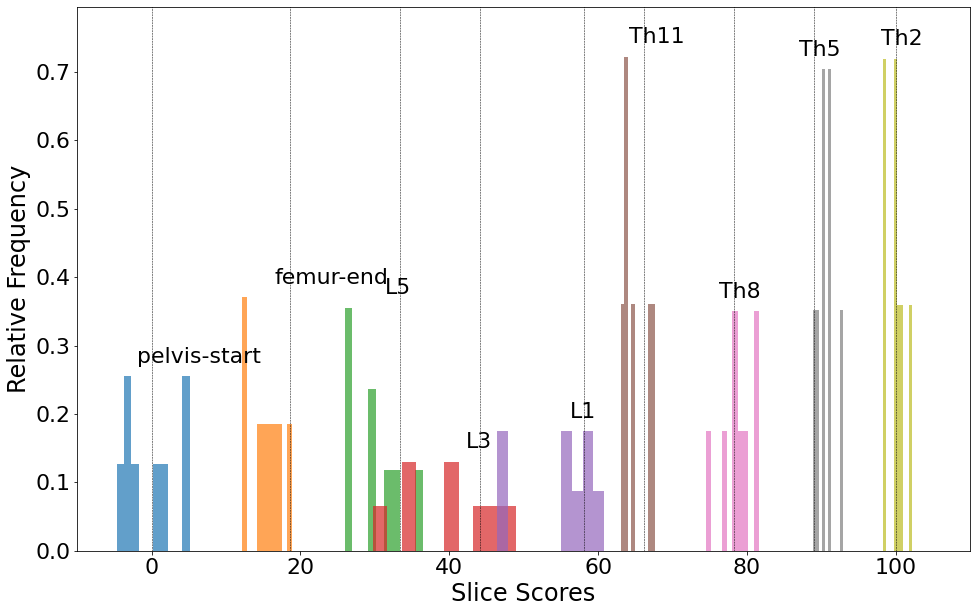

In [16]:
# Plot histograms for each landmark 
modelEval.plot_landmarks()

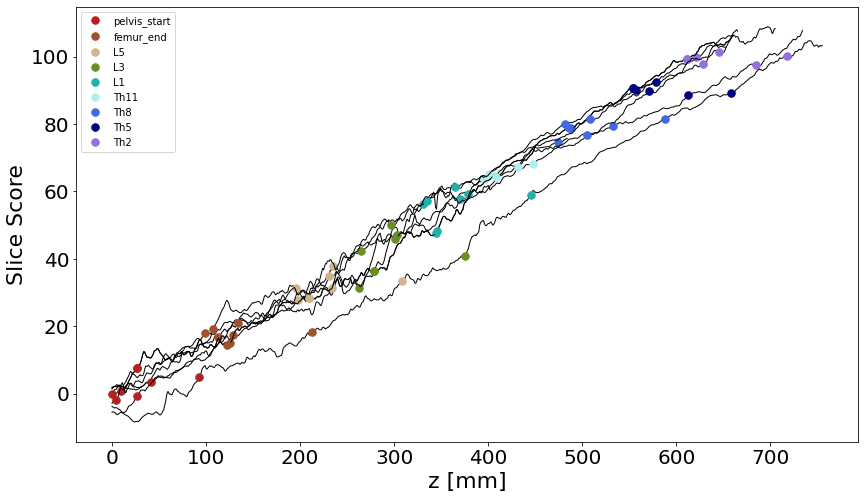

In [17]:
# plot scores of each volume from the test dataset
from bpreg.evaluation.validation_volume import ValidationVolume

expected_scores = modelEval.landmark_score_bundle.dict["train"].expected_scores
vol = ValidationVolume(modelEval.inference_model, modelEval.test_dataset, 0, expected_scores)
vol.plot_scores(set_figsize=(12, 8), legend=True)

for i in range(1, len(modelEval.val_dataset)): 
    vol = ValidationVolume(modelEval.inference_model, modelEval.test_dataset, i, expected_scores)
    vol.plot_scores()


plot slices from test set near scores: [10 30 50 70 90]


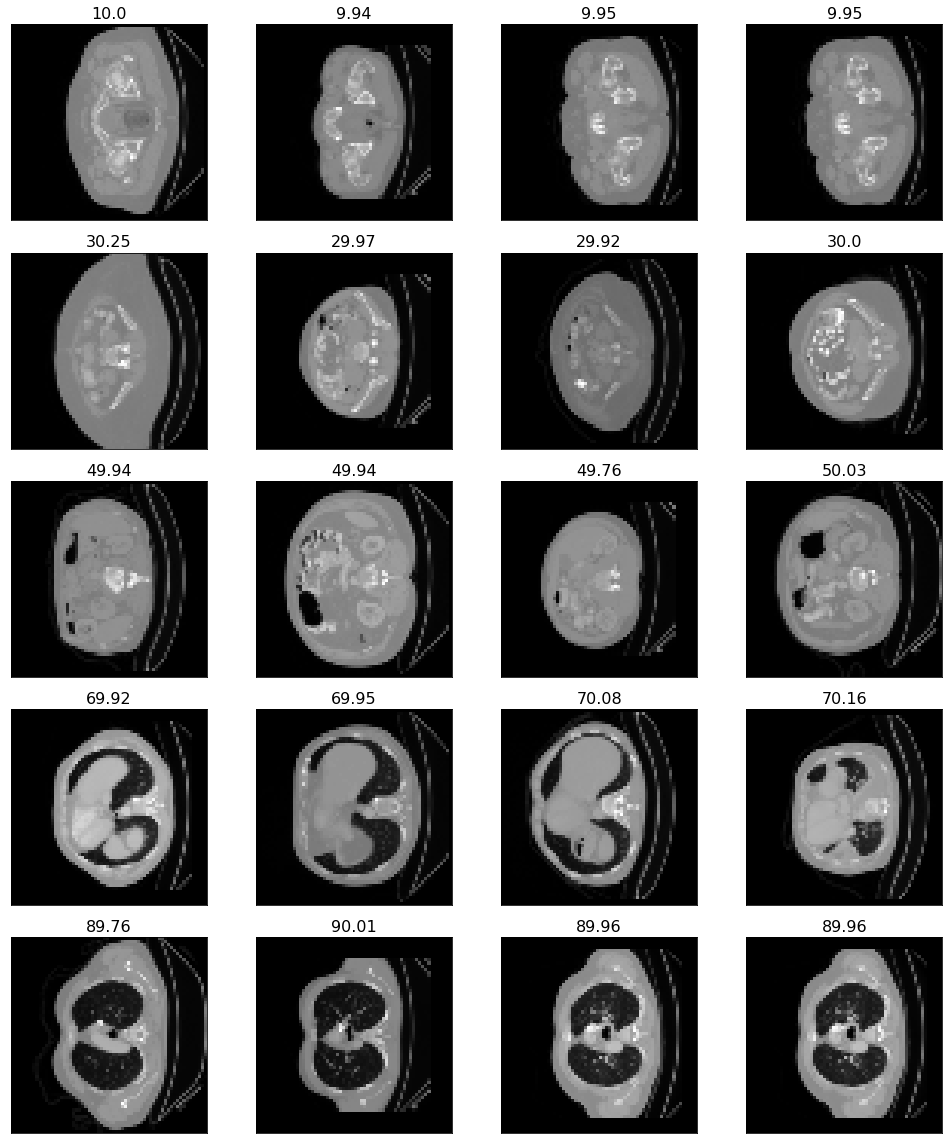

In [18]:
nearby_values=np.arange(10, 100, 20)
print(f"plot slices from test set near scores: {nearby_values}")
modelEval.plot_slices2scores(max_cols=4, nearby_values=nearby_values)